In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift
from scipy.signal import correlate

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
def crosscorr_reprojection(data, entries):
    
    ang = tomopy.angles(data[0][0][0, 0].shape[0])
    _rec = 1e-12 * np.ones((data[0][0][0, 0].shape[1], data[0][0][0, 0].shape[2], data[0][0][0, 0].shape[2]))
    data_copy = data.copy()
    out_data = np.zeros((entries, 2), dtype = object)
    
    for i in range (entries):
    
        out_data[i, 0] = np.zeros((1, 1, data[0][0][0, 0].shape[0], data[0][0][0, 0].shape[1] * 2 - 1,
                                      data[0][0][0, 0].shape[2] * 2 - 1))
        out_data[i, 1] = data_copy[i, 1]
        
        rec = tomopy.recon(data_copy[i][0][0, 0], ang, center = None, 
                            algorithm = 'mlem', init_recon = _rec)
        reproj = tomopy.project(rec, ang, center = None, pad = False)
        
        for j in range (data[0][0][0, 0].shape[0]):
            
            out_data[i, 0][0, 0, j] = correlate(data_copy[i][0][0, 0, j], reproj[j], method = 'fft')
        
    return out_data

In [4]:
def to_projections(data, entries):
    
    projections = np.zeros((entries * data[0][0][0, 0].shape[0], 2), dtype = object)

    for i in range (entries):

        for j in range (data[0][0][0, 0].shape[0]):

            projections[i * data[0][0][0, 0].shape[0] + j, 0] = data[i, 0][0, 0, j, :, :]
            projections[i * data[0][0][0, 0].shape[0] + j, 1] = np.asarray([data[i, 1][0, 2 * j], 
                                                                            data[i, 1][0, 2 * j + 1]])
            
    return projections

In [5]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 25
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)
angles = entries * data[0][0][0, 0].shape[0]
print("Total Projections: {}".format(angles))
crosscorr_reproj = crosscorr_reprojection(data, entries)
crosscorr_data = to_projections(crosscorr_reproj, entries)

Total Projections: 4500


In [6]:
for i in range (crosscorr_data.shape[0]):
    
    crosscorr_data[i, 0] = np.expand_dims(crosscorr_data[i, 0], axis = 0)
    crosscorr_data[i, 0] = np.expand_dims(crosscorr_data[i, 0], axis = 0)
    crosscorr_data[i, 1] = np.expand_dims(crosscorr_data[i, 1], axis = 0)
    
print(crosscorr_data.shape)
print(crosscorr_data[0, 0].shape)
print(crosscorr_data[0, 1].shape)

(4500, 2)
(1, 1, 255, 367)
(1, 2)


In [7]:
# Checking shape of training and testing splits
trainset, testset = np.split(crosscorr_data, [int(angles * 4 / 5)])
print("Shape of Training Dataset: {}".format(trainset.shape))
print("Shape of Testing Dataset: {}".format(testset.shape))

Shape of Training Dataset: (3600, 2)
Shape of Testing Dataset: (900, 2)


In [8]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3 kernel convolution
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1 kernel convolution
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=2):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv2d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7),
                               stride=(conv1_t_stride, 2),
                               padding=(conv1_t_size // 2, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool2d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm2d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [9]:
model = generate_model(18)
summary(model, (1, 1, 255, 367))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 255, 184]         3,136
├─BatchNorm2d: 1-2                       [1, 64, 255, 184]         128
├─ReLU: 1-3                              [1, 64, 255, 184]         --
├─MaxPool2d: 1-4                         [1, 64, 128, 92]          --
├─Sequential: 1-5                        [1, 64, 128, 92]          --
│    └─BasicBlock: 2-1                   [1, 64, 128, 92]          --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 92]          36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 92]          128
│    │    └─ReLU: 3-3                    [1, 64, 128, 92]          --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 92]          36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 92]          128
│    │    └─ReLU: 3-6                    [1, 64, 128, 92]          --
│

In [16]:
# Clear CUDA cache
torch.cuda.empty_cache()
print("Cleared Cache")

# Train the model

# Create writer and profiler to analyze loss over each epoch
# writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(18)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 1e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 1000

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device).float()), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        # writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device).float()), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        # writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
# writer.flush()
# writer.close()

Cleared Cache
Device: cuda:0
Epoch: 0   Training Loss: 9.240803234628814 
Epoch: 0   Validation Loss: 7.971414697913246 
Epoch: 1   Training Loss: 8.964900368662367 
Epoch: 1   Validation Loss: 7.971401303205639 
Epoch: 2   Training Loss: 8.964852604303486 
Epoch: 2   Validation Loss: 7.971389439401941 
Epoch: 3   Training Loss: 8.96484365142682 
Epoch: 3   Validation Loss: 7.971380442697555 
Epoch: 4   Training Loss: 8.96483930239104 
Epoch: 4   Validation Loss: 7.971373918820173 
Epoch: 5   Training Loss: 8.964835091195015 
Epoch: 5   Validation Loss: 7.971366627677861 
Epoch: 6   Training Loss: 8.96483303369315 
Epoch: 6   Validation Loss: 7.971361375873287 
Epoch: 7   Training Loss: 8.96482993081446 
Epoch: 7   Validation Loss: 7.971354872553299 
Epoch: 8   Training Loss: 8.964828174851966 
Epoch: 8   Validation Loss: 7.9713510549772115 
Epoch: 9   Training Loss: 8.964826019524338 
Epoch: 9   Validation Loss: 7.9713471342850895 
Epoch: 10   Training Loss: 8.964824697805044 
Epoch: 

Epoch: 87   Validation Loss: 7.969192136795156 
Epoch: 88   Training Loss: 8.963627031908901 
Epoch: 88   Validation Loss: 7.969343194746309 
Epoch: 89   Training Loss: 8.963620647866435 
Epoch: 89   Validation Loss: 7.969079024090121 
Epoch: 90   Training Loss: 8.963519303480732 
Epoch: 90   Validation Loss: 7.969173980582919 
Epoch: 91   Training Loss: 8.963693568915785 
Epoch: 91   Validation Loss: 7.968799661640078 
Epoch: 92   Training Loss: 8.963324936939058 
Epoch: 92   Validation Loss: 7.968986876767335 
Epoch: 93   Training Loss: 8.964549310307792 
Epoch: 93   Validation Loss: 7.97153124311318 
Epoch: 94   Training Loss: 8.963913773849717 
Epoch: 94   Validation Loss: 7.971597902309667 
Epoch: 95   Training Loss: 8.963504309119582 
Epoch: 95   Validation Loss: 7.970633585225377 
Epoch: 96   Training Loss: 8.963526762259102 
Epoch: 96   Validation Loss: 7.972467625142696 
Epoch: 97   Training Loss: 8.963503910681142 
Epoch: 97   Validation Loss: 7.973120816560048 
Epoch: 98   T

Epoch: 173   Validation Loss: 7.964006282478157 
Epoch: 174   Training Loss: 8.956573476295 
Epoch: 174   Validation Loss: 7.960960548007085 
Epoch: 175   Training Loss: 8.955215833051172 
Epoch: 175   Validation Loss: 7.964648287434959 
Epoch: 176   Training Loss: 8.955221718289863 
Epoch: 176   Validation Loss: 7.967397678071737 
Epoch: 177   Training Loss: 8.955881865969827 
Epoch: 177   Validation Loss: 7.958489487439187 
Epoch: 178   Training Loss: 8.953696906149593 
Epoch: 178   Validation Loss: 7.961642695889523 
Epoch: 179   Training Loss: 8.954264124152639 
Epoch: 179   Validation Loss: 7.9586089707036605 
Epoch: 180   Training Loss: 8.952327148203185 
Epoch: 180   Validation Loss: 7.961215146230275 
Epoch: 181   Training Loss: 8.952514264255685 
Epoch: 181   Validation Loss: 7.955574011982212 
Epoch: 182   Training Loss: 8.954062790695236 
Epoch: 182   Validation Loss: 7.955806107110499 
Epoch: 183   Training Loss: 8.956366416558094 
Epoch: 183   Validation Loss: 7.9565445523

Epoch: 259   Training Loss: 8.924754045706658 
Epoch: 259   Validation Loss: 7.992992564126293 
Epoch: 260   Training Loss: 8.923339026973638 
Epoch: 260   Validation Loss: 8.004443848559168 
Epoch: 261   Training Loss: 8.951063028142025 
Epoch: 261   Validation Loss: 7.989003085090113 
Epoch: 262   Training Loss: 8.947555794249872 
Epoch: 262   Validation Loss: 7.99608802741581 
Epoch: 263   Training Loss: 8.93528153611336 
Epoch: 263   Validation Loss: 8.006893566239192 
Epoch: 264   Training Loss: 8.93863078866445 
Epoch: 264   Validation Loss: 7.987270003818234 
Epoch: 265   Training Loss: 8.943397084468485 
Epoch: 265   Validation Loss: 7.981693161450481 
Epoch: 266   Training Loss: 8.938404146405382 
Epoch: 266   Validation Loss: 7.9802500978804245 
Epoch: 267   Training Loss: 8.931432784193085 
Epoch: 267   Validation Loss: 7.994579231672817 
Epoch: 268   Training Loss: 8.933773420125387 
Epoch: 268   Validation Loss: 7.976627403627305 
Epoch: 269   Training Loss: 8.940115182636

Epoch: 345   Training Loss: 8.855420705784542 
Epoch: 345   Validation Loss: 7.940552575212205 
Epoch: 346   Training Loss: 8.85189791140111 
Epoch: 346   Validation Loss: 7.9450338394667455 
Epoch: 347   Training Loss: 8.847073488406863 
Epoch: 347   Validation Loss: 7.952494457086238 
Epoch: 348   Training Loss: 8.835480332371857 
Epoch: 348   Validation Loss: 7.958038565236364 
Epoch: 349   Training Loss: 8.869549189933377 
Epoch: 349   Validation Loss: 7.976885374194179 
Epoch: 350   Training Loss: 8.90357335514832 
Epoch: 350   Validation Loss: 7.974188301239111 
Epoch: 351   Training Loss: 8.90077919668454 
Epoch: 351   Validation Loss: 7.961484642053515 
Epoch: 352   Training Loss: 8.882128242143452 
Epoch: 352   Validation Loss: 7.969282296348829 
Epoch: 353   Training Loss: 8.85870627965086 
Epoch: 353   Validation Loss: 7.957329519695712 
Epoch: 354   Training Loss: 8.84542573032532 
Epoch: 354   Validation Loss: 7.991027231883672 
Epoch: 355   Training Loss: 8.81991095889393

Epoch: 431   Training Loss: 8.628571062054576 
Epoch: 431   Validation Loss: 8.114314519470403 
Epoch: 432   Training Loss: 8.662710923213627 
Epoch: 432   Validation Loss: 8.135803086086979 
Epoch: 433   Training Loss: 8.859503531498728 
Epoch: 433   Validation Loss: 7.9978047853467675 
Epoch: 434   Training Loss: 8.857712310622478 
Epoch: 434   Validation Loss: 8.047552755385016 
Epoch: 435   Training Loss: 8.971725117496163 
Epoch: 435   Validation Loss: 7.954227244625541 
Epoch: 436   Training Loss: 8.922816186748063 
Epoch: 436   Validation Loss: 7.98424946219324 
Epoch: 437   Training Loss: 8.941295373671526 
Epoch: 437   Validation Loss: 7.9782139408335855 
Epoch: 438   Training Loss: 8.92879944525655 
Epoch: 438   Validation Loss: 8.016834487537013 
Epoch: 439   Training Loss: 8.922742632348292 
Epoch: 439   Validation Loss: 8.020634691490947 
Epoch: 440   Training Loss: 8.885272884830826 
Epoch: 440   Validation Loss: 8.044412443811437 
Epoch: 441   Training Loss: 8.8757011657

Epoch: 517   Training Loss: 8.972833305342535 
Epoch: 517   Validation Loss: 7.971459266138586 
Epoch: 518   Training Loss: 8.949703449241238 
Epoch: 518   Validation Loss: 7.9679273067735545 
Epoch: 519   Training Loss: 8.928111251295963 
Epoch: 519   Validation Loss: 7.971539766204336 
Epoch: 520   Training Loss: 8.923274184527912 
Epoch: 520   Validation Loss: 7.986496067234936 
Epoch: 521   Training Loss: 8.904993258145774 
Epoch: 521   Validation Loss: 8.015886353183951 
Epoch: 522   Training Loss: 8.893437891084197 
Epoch: 522   Validation Loss: 8.04069709660589 
Epoch: 523   Training Loss: 8.86769794317053 
Epoch: 523   Validation Loss: 8.081581752825942 
Epoch: 524   Training Loss: 8.83358141633572 
Epoch: 524   Validation Loss: 8.102196480038886 
Epoch: 525   Training Loss: 8.821417425725349 
Epoch: 525   Validation Loss: 8.1465930811709 
Epoch: 526   Training Loss: 8.80418453933309 
Epoch: 526   Validation Loss: 8.136449986772302 
Epoch: 527   Training Loss: 8.766382313580124

Epoch: 603   Training Loss: 8.2985965213112 
Epoch: 603   Validation Loss: 8.565871568241985 
Epoch: 604   Training Loss: 8.291274769363065 
Epoch: 604   Validation Loss: 8.863749456700559 
Epoch: 605   Training Loss: 8.29133388624748 
Epoch: 605   Validation Loss: 8.530384405882408 
Epoch: 606   Training Loss: 8.097230738245287 
Epoch: 606   Validation Loss: 8.375620662283358 
Epoch: 607   Training Loss: 8.250327407221128 
Epoch: 607   Validation Loss: 8.23284300910461 
Epoch: 608   Training Loss: 7.878256709138902 
Epoch: 608   Validation Loss: 8.784300558661215 
Epoch: 609   Training Loss: 7.873372659520327 
Epoch: 609   Validation Loss: 8.446984154554084 
Epoch: 610   Training Loss: 7.738713520105011 
Epoch: 610   Validation Loss: 8.506682863615634 
Epoch: 611   Training Loss: 7.642858307618978 
Epoch: 611   Validation Loss: 8.537008507168956 
Epoch: 612   Training Loss: 7.467420961181989 
Epoch: 612   Validation Loss: 8.149905760992164 
Epoch: 613   Training Loss: 9.00235572292160

Epoch: 689   Training Loss: 8.397100675695789 
Epoch: 689   Validation Loss: 8.448954177054627 
Epoch: 690   Training Loss: 8.242507278336156 
Epoch: 690   Validation Loss: 8.455726723877403 
Epoch: 691   Training Loss: 8.127625343315978 
Epoch: 691   Validation Loss: 8.481616777291315 
Epoch: 692   Training Loss: 7.959941431357333 
Epoch: 692   Validation Loss: 8.635552485166118 
Epoch: 693   Training Loss: 8.207530578437995 
Epoch: 693   Validation Loss: 8.136254728154487 
Epoch: 694   Training Loss: 8.729662541312186 
Epoch: 694   Validation Loss: 8.260385480561915 
Epoch: 695   Training Loss: 8.15520393832876 
Epoch: 695   Validation Loss: 8.594867693719765 
Epoch: 696   Training Loss: 7.994836888461917 
Epoch: 696   Validation Loss: 8.390302015222712 
Epoch: 697   Training Loss: 7.8867910879047285 
Epoch: 697   Validation Loss: 8.416291562283618 
Epoch: 698   Training Loss: 7.577005043587172 
Epoch: 698   Validation Loss: 8.429237586616848 
Epoch: 699   Training Loss: 8.6686978217

Epoch: 775   Training Loss: 7.215762417130981 
Epoch: 775   Validation Loss: 9.834297890997389 
Epoch: 776   Training Loss: 7.070482763633611 
Epoch: 776   Validation Loss: 9.35634221323423 
Epoch: 777   Training Loss: 6.918762207923994 
Epoch: 777   Validation Loss: 9.736223378608573 
Epoch: 778   Training Loss: 7.833765087975371 
Epoch: 778   Validation Loss: 8.1800840837793 
Epoch: 779   Training Loss: 8.217268046329547 
Epoch: 779   Validation Loss: 9.431155832424347 
Epoch: 780   Training Loss: 6.69024487110107 
Epoch: 780   Validation Loss: 9.735088174091652 
Epoch: 781   Training Loss: 6.435493433882657 
Epoch: 781   Validation Loss: 10.05950081429496 
Epoch: 782   Training Loss: 7.544801487838834 
Epoch: 782   Validation Loss: 9.372794355696985 
Epoch: 783   Training Loss: 7.751121728160328 
Epoch: 783   Validation Loss: 9.652785238111909 
Epoch: 784   Training Loss: 7.083519052748573 
Epoch: 784   Validation Loss: 9.20474838113468 
Epoch: 785   Training Loss: 6.64206113236911 

Epoch: 860   Validation Loss: 7.982275622870074 
Epoch: 861   Training Loss: 8.852028583480601 
Epoch: 861   Validation Loss: 8.069880749433974 
Epoch: 862   Training Loss: 8.784415720312666 
Epoch: 862   Validation Loss: 8.06780714410965 
Epoch: 863   Training Loss: 8.693239134857011 
Epoch: 863   Validation Loss: 8.064395244266036 
Epoch: 864   Training Loss: 8.583372731771977 
Epoch: 864   Validation Loss: 8.31666623294664 
Epoch: 865   Training Loss: 8.417945380986072 
Epoch: 865   Validation Loss: 8.317148148360817 
Epoch: 866   Training Loss: 8.23944936607425 
Epoch: 866   Validation Loss: 8.534124282456938 
Epoch: 867   Training Loss: 7.998793069905239 
Epoch: 867   Validation Loss: 8.82585634978569 
Epoch: 868   Training Loss: 7.7452655884981825 
Epoch: 868   Validation Loss: 8.754511472837637 
Epoch: 869   Training Loss: 7.4216540557862185 
Epoch: 869   Validation Loss: 8.650334246846226 
Epoch: 870   Training Loss: 7.156588298068964 
Epoch: 870   Validation Loss: 8.7632003935

Epoch: 946   Training Loss: 5.3139052837443 
Epoch: 946   Validation Loss: 10.568911020589164 
Epoch: 947   Training Loss: 5.06991686065365 
Epoch: 947   Validation Loss: 10.860345400113923 
Epoch: 948   Training Loss: 5.13493608993405 
Epoch: 948   Validation Loss: 11.352784692559961 
Epoch: 949   Training Loss: 4.917036545639599 
Epoch: 949   Validation Loss: 11.414989348426978 
Epoch: 950   Training Loss: 4.484607281385019 
Epoch: 950   Validation Loss: 11.273111570672029 
Epoch: 951   Training Loss: 4.455954083712875 
Epoch: 951   Validation Loss: 11.3093341026807 
Epoch: 952   Training Loss: 7.608833608557503 
Epoch: 952   Validation Loss: 8.28567190156079 
Epoch: 953   Training Loss: 7.193918357086239 
Epoch: 953   Validation Loss: 10.796449430983824 
Epoch: 954   Training Loss: 6.046752243204586 
Epoch: 954   Validation Loss: 11.576173755279225 
Epoch: 955   Training Loss: 5.405814565598719 
Epoch: 955   Validation Loss: 11.910871657841943 
Epoch: 956   Training Loss: 4.91919624

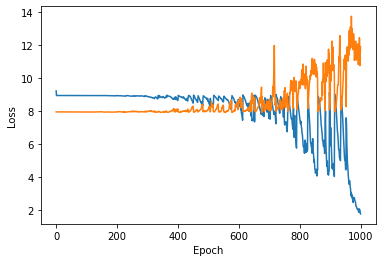

In [17]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()